In [55]:
import numpy as np
import matplotlib as plt
import warnings
warnings.filterwarnings('ignore')

In [56]:
import pandas as pd

In [57]:
df = pd.read_csv("SpeedVideoDataforModeling.csv")

In [58]:
df.head()

,Video Initial Max DL Rate(kbps),E2E RTT(ms),Average Rate of Playing phase (kbps),Initial Buffering Latency(ms),Stalling Ratio,Video Total DL Rate(kbps),Stalling Length,Playing Length,Total time of Playing phase (kbps),Stalling times,video bitrate,Video Initial buffer download,SQuality,SLoading,Stalling,VMoS
0,49450,54,3719,1108,0.0,3795.0,0,30013,30013,0,2934,1645944,4.33,4.04,5.0,3.96
1,50517,52,5902,1095,0.0,5859.0,0,30006,30006,0,2903,1555356,4.33,4.05,5.0,3.96
2,47988,47,5806,1051,0.0,5857.0,0,30006,30006,0,2903,1535444,4.33,4.08,5.0,3.98
3,56457,55,5978,1099,0.0,5989.0,0,30003,30003,0,2903,1534092,4.33,4.05,5.0,3.96
4,56690,54,5931,1133,0.0,5932.0,0,30005,30005,0,2934,1582192,4.33,4.02,5.0,3.95


In [59]:
df.shape

(178532, 16)

<AxesSubplot: ylabel='Density'>

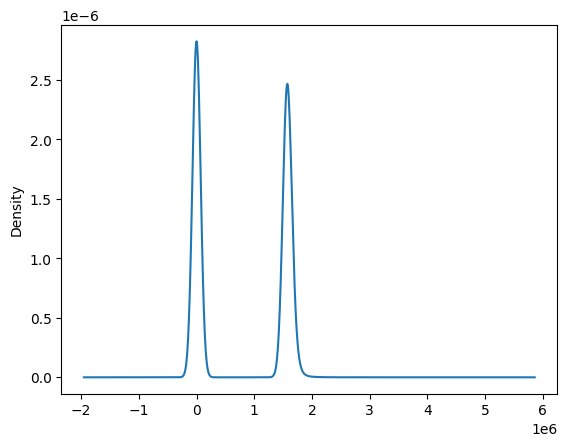

In [60]:
df['SQuality'].plot(kind='kde')

<AxesSubplot: ylabel='Frequency'>

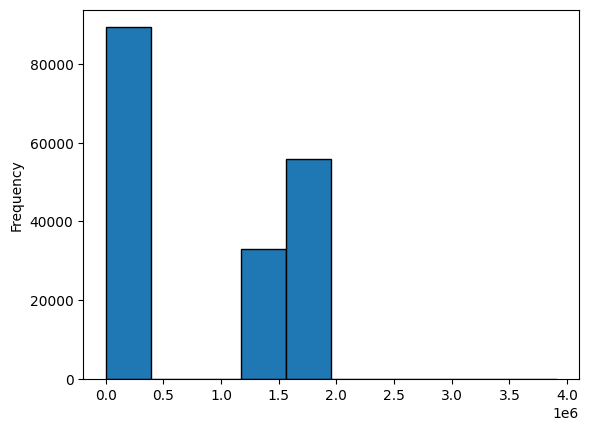

In [61]:
df['SQuality'].plot(kind='hist', edgecolor='black')

<AxesSubplot: ylabel='Frequency'>

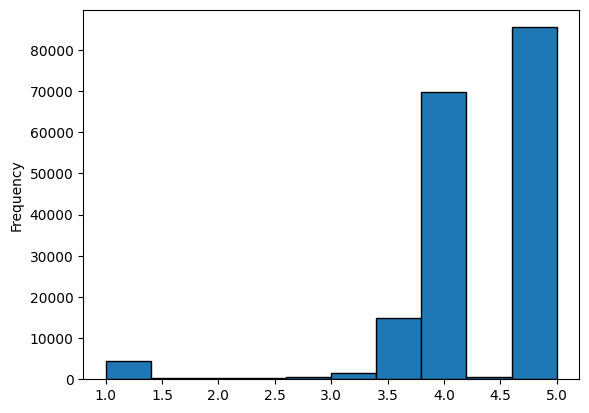

In [62]:
df['VMoS'].plot(kind='hist', edgecolor='black')

<AxesSubplot: ylabel='Frequency'>

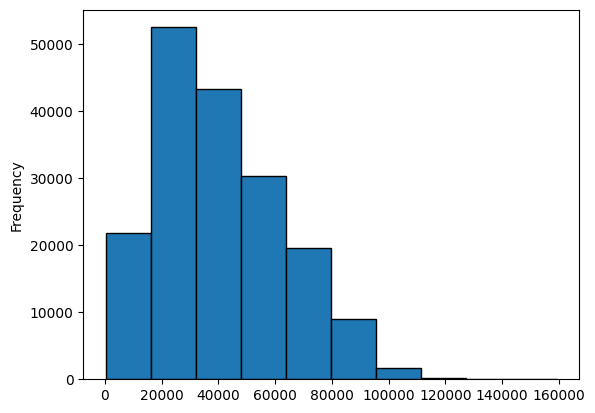

In [63]:
df['Video Initial Max DL Rate(kbps)'].plot(kind='hist', edgecolor='black')

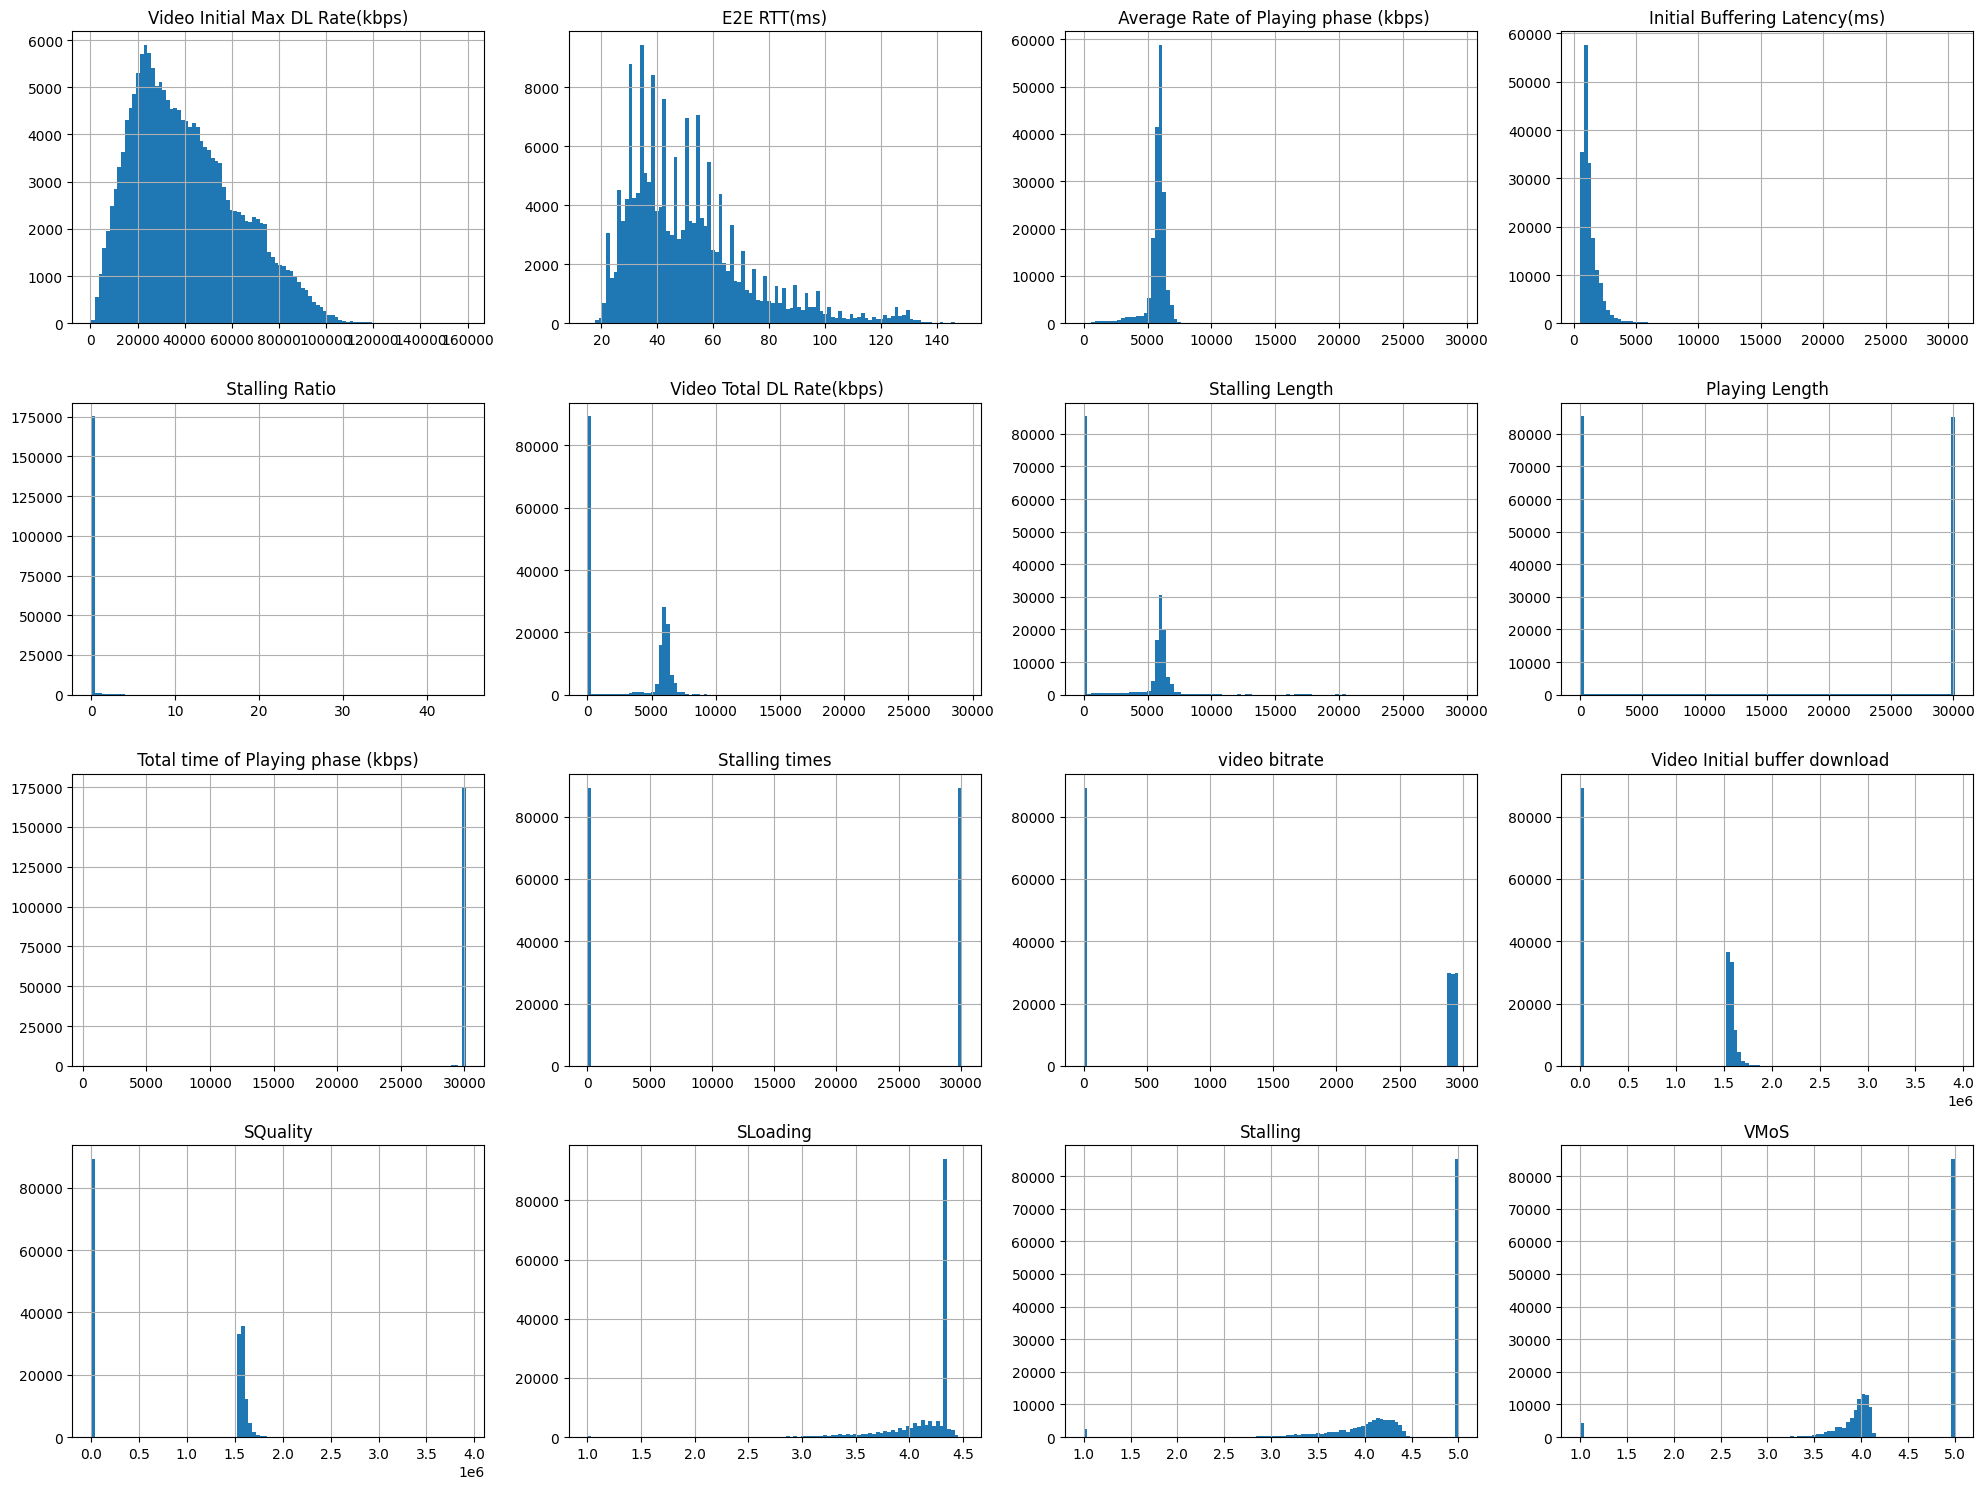

In [64]:
# Plot the histograms for all columns in the DataFrame
import matplotlib.pyplot as plt
df.hist(bins=100, figsize=(20,15))
plt.tight_layout()
plt.show()

### Made a pandas profiling report for the dataset:

In [65]:
import pandas_profiling as pp
profile = pp.ProfileReport(df)
profile.to_file("output.html")

Export report to file: 100%|██████████████████████| 1/1 [00:00<00:00, 26.86it/s]


<AxesSubplot: xlabel='video bitrate', ylabel='VMoS'>

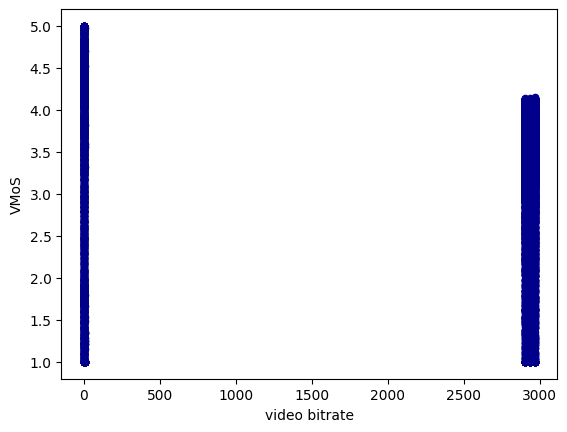

In [66]:
df.plot.scatter(x='video bitrate', y='VMoS', c='DarkBlue')

<AxesSubplot: ylabel='Frequency'>

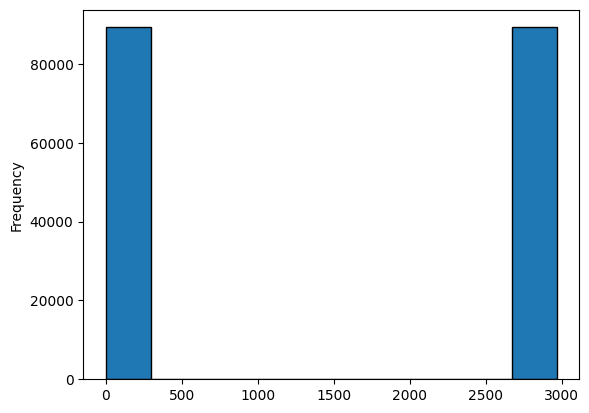

In [67]:
df['video bitrate'].plot(kind='hist', edgecolor='black')

### Applying multiple linear regression first: 

In [68]:
column_headers = list(df.columns.values)
used_columns = column_headers[3:-1]
used_columns

['Initial Buffering Latency(ms)',
 ' Stalling Ratio',
 ' Video Total DL Rate(kbps)',
 'Stalling Length',
 'Playing Length',
 ' Total time of Playing phase (kbps) ',
 'Stalling times',
 'video bitrate',
 ' Video Initial buffer download',
 'SQuality',
 'SLoading',
 'Stalling']

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

data = df

# Select the columns to be used for the regression
columns = used_columns
X = data[columns]
y = data['VMoS']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train the multiple linear regression model
reg = LinearRegression().fit(X_train, y_train)

# Predict the target variable for the test data
y_pred = reg.predict(X_test)

# Evaluate the model's performance
mse = np.mean((y_pred - y_test)**2)
print("Mean Squared Error:", mse)

# Print the coefficient and intercept of the model
print("Coefficients:", reg.coef_)
print("Intercept:", reg.intercept_)

Mean Squared Error: 0.03650301482085456
Coefficients: [ 1.33869030e-04  6.95710896e-02  1.27079715e-05  7.11430006e-05
  1.19663396e-04  3.50166354e-04  1.70364643e-04 -1.12013789e-04
  2.32443274e-07 -3.79482142e-07  7.01533045e-01  4.16534488e-01]
Intercept: -15.332094258255147


### Trying to predict VMoS values for a data-point: 

In [70]:
# Create a new data point
new_data = np.array([[1108, 0.0, 3795.0, 0, 30013, 30013, 0, 2934, 1645944, 4.33, 4.04, 5.0]])

# Use the trained model to predict the target variable for the new data
new_prediction = reg.predict(new_data)

# Print the prediction
print("Prediction:", new_prediction[0])

Prediction: 3.936264120696933


### Now, using XGBoost

In [74]:
column_headers = list(df.columns.values)
used_columns = column_headers[3:-1]
used_columns

['Initial Buffering Latency(ms)',
 ' Stalling Ratio',
 ' Video Total DL Rate(kbps)',
 'Stalling Length',
 'Playing Length',
 ' Total time of Playing phase (kbps) ',
 'Stalling times',
 'video bitrate',
 ' Video Initial buffer download',
 'SQuality',
 'SLoading',
 'Stalling']

In [78]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split

data = df

# Select the columns to be used for the regression
columns = used_columns
X = data[columns]
y = data['VMoS']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=0)

# Convert the data into the format that XGBoost requires
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the XGBoost parameters
params = {
    'objective': 'reg:linear',
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'seed': 0
}

# Train the XGBoost model
model = xgb.train(params, dtrain)

# Predict the target variable for the test data
y_pred = model.predict(dtest)

# Evaluate the model's performance
mse = np.mean((y_pred - y_test)**2)
print("Mean Squared Error:", mse)
data.head()

[23:01:34] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[23:01:34] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

Mean Squared Error: 1.8837614171488792


,Video Initial Max DL Rate(kbps),E2E RTT(ms),Average Rate of Playing phase (kbps),Initial Buffering Latency(ms),Stalling Ratio,Video Total DL Rate(kbps),Stalling Length,Playing Length,Total time of Playing phase (kbps),Stalling times,video bitrate,Video Initial buffer download,SQuality,SLoading,Stalling,VMoS
0,49450,54,3719,1108,0.0,3795.0,0,30013,30013,0,2934,1645944,4.33,4.04,5.0,3.96
1,50517,52,5902,1095,0.0,5859.0,0,30006,30006,0,2903,1555356,4.33,4.05,5.0,3.96
2,47988,47,5806,1051,0.0,5857.0,0,30006,30006,0,2903,1535444,4.33,4.08,5.0,3.98
3,56457,55,5978,1099,0.0,5989.0,0,30003,30003,0,2903,1534092,4.33,4.05,5.0,3.96
4,56690,54,5931,1133,0.0,5932.0,0,30005,30005,0,2934,1582192,4.33,4.02,5.0,3.95


### Now, trying to predict the values for a data-point: 

In [79]:
# Create a new data point
new_data = np.array([[1108, 0.0, 3795.0, 0, 30013, 30013, 0, 2934, 1645944, 4.33, 4.04, 5.0]])

# Convert the data into the format that XGBoost requires
dnew = xgb.DMatrix(new_data)

# Use the trained model to make a prediction for the new data
new_prediction = model.predict(dnew)

# Print the prediction
print("Prediction:", new_prediction[0])


Prediction: 2.754167
